(0.0, 100.0)

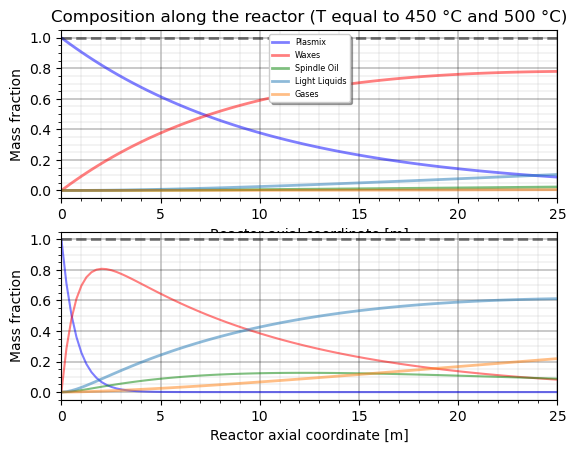

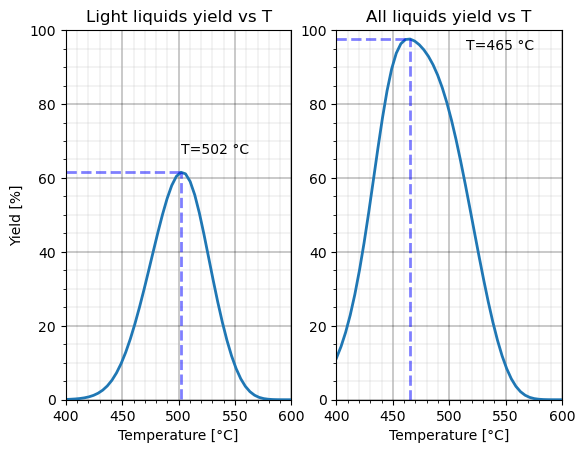

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## DENSITIES ESTIMATED FROM FLOWSHEET (simPyrMod)
rho_h2o     = 1000  # [Kg/m3] density of water
rho_plasmix = 981.4 # [Kg/m3] plastic waste mixture density
rho_GandL   = 1.474 # [Kg/m3] density of G + L products (all in vapor phase)
rho_S       = 1717  # [Kg/m3] density of solids (ashes + char)

## MASS RATIOS
# inlet
ratio_moisture = 0.01
ratio_plasmix  = 0.99
# outlet
ratio_GandL = 0.9
ratio_S     = 0.1

## FIRST ATTEMPT: DENSITY IS CONSTANT ALL OVER THE REACTOR AND EQUAL TO THE ARITMETIC AVERAGE BETWEEN INLET AND OUTLET
rho_in  = 1/(ratio_moisture / rho_h2o + ratio_plasmix / rho_plasmix) # [Kg/m3]
rho_out = 1/(ratio_GandL / rho_GandL + ratio_S / rho_S) # [Kg/m3]

rho = (rho_in + rho_out) / 2                                     # [Kg/m3]

## ROUGH ESTIMATION OF AVERAGE VELOCITY THROUGH THE REACTOR
mfr = 2000/1000/60; # [Kg/min] mass flow rate; close to Test run 37 pag 8 of ref
L   = 25;           # [m] reactor length
d   = 4.3*1e-3      # [m]   reactor diameter
A   = np.pi*np.power(d, 2)/4                  # [m2]  reactor sectional area
v   = mfr/rho/A/60                            # [m/s] average velocity                    

T = 450 + 273.15 # [K] reactor temperature (isothermal)

## ISOTHERMAL REACTOR: TEMPERATURE KNOWN, KINETIC CONSTANTS EVALUATED HERE      
A = np.array([3.2e15, 4.1e15, 6.1e11, 4.7e14, 9.8e15, 1.8e15, 3.2e10]) # Apparent frequency factors [1/s]
E = np.array([244,    270,    208,    269,    271,    271,    199])    # Apparent activation energies [KJ/mol]

## FUNCTION: PFR MODEL 
def PyrPFR(z, c, T, A, E, w):
    
    R = 8.314 * 1e-3 # universal gas constant [kJ/mol/K]
    
    c_p, c_w, c_s, c_l = c[0:4]
    k =  A * np.exp(-E/(R*T))
    kPx = k[0]
    
    dc_pdz = - kPx * c_p / w
    dc_wdz = (kPx * c_p - k[1] * c_w - k[2] * c_w - k[3] * c_w) / w
    dc_sdz = (k[1] * c_w - k[4] * c_s - k[5] * c_s) / w
    dc_ldz = (k[2] * c_w + k[4] * c_s - k[6] * c_l) / w
    dc_gdz = (k[3] * c_w + k[5] * c_s + k[6] * c_l) / w
    
    return dc_pdz, dc_wdz, dc_sdz, dc_ldz, dc_gdz

## SYSTEM RESOLUTION
# First case: mass fractions along the reactor for T = 450 °C 
Lspan  = [0, L]                 # space span for the ODE resolution [m]
y0     = [1, 0, 0, 0, 0]        # inlet mass fractions (1 for plasmix, 0 for every pyrolysis product)
L_eval = np.linspace(0, L, 100) # points for the solution output
c1 = solve_ivp(PyrPFR, Lspan, y0, t_eval=L_eval, method='RK45', args=(T, A, E, v))
# Check vector: mass fraction must be = 1 in every point of the reactor
y_star = np.cumsum(c1.y, axis = 0)
check = y_star[4, :]

# Second case: mass fractions along the reactor for T = 500 °C
T2 = 500 + 273.15 # [K] temperature of this second ODE system resolution
c2 = solve_ivp(PyrPFR, Lspan, y0, t_eval=L_eval, method='RK45', args=(T2, A, E, v))
y_star2 = np.cumsum(c2.y, axis = 0)
check2 = y_star2[4, :]

# Third and fourth cases: products yield vs different T
N=50 # number of temperature values
T_test = np.linspace(400,600,N)+273.15
yP = np.zeros([N, 100])
yW = np.zeros([N, 100])
yS = np.zeros([N, 100])
yL = np.zeros([N, 100])
yG = np.zeros([N, 100])

for i in range(N):
    c_test = solve_ivp(PyrPFR, Lspan, y0, t_eval=L_eval, method='RK45', args=(T_test[i], A, E, v))
    yP[i, :] = c_test.y[0]
    yW[i, :] = c_test.y[1]
    yS[i, :] = c_test.y[2]
    yL[i, :] = c_test.y[3]
    yG[i, :] = c_test.y[4]
    
checkRes = yP + yW + yS + yL + yG

# Light Liquids Yield
Y_LL = yL[:, -1] * 100 
Y_LLmax = np.argmax(Y_LL)

# All Liquids Yield
Y_All_L = (yW[:, -1] + yS[:, -1] + yL[:, -1]) * 100
Y_All_Lmax = np.argmax(Y_All_L)

## POST PROCESSING
# First and second cases: mass fraction evolution along the reactor axis 
# Third and fourth cases: yield of LL and All L w. r. t. temperature
# First case
fig1, axs1 = plt.subplots(2, 1)
axs1[0].plot(c1.t, c1.y[0], 'b', alpha = 0.5, lw=2, label='Plasmix')
axs1[0].plot(c1.t, c1.y[1], 'r', alpha = 0.5, lw=2, label='Waxes')
axs1[0].plot(c1.t, c1.y[2], 'g', alpha = 0.5, lw=2, label='Spindle Oil')
axs1[0].plot(c1.t, c1.y[3], alpha = 0.5, lw=2, label='Light Liquids')
axs1[0].plot(c1.t, c1.y[4], alpha = 0.5, lw=2, label='Gases')
axs1[0].plot(c1.t, check, 'k--', alpha = 0.5, lw=2) # mass fraction must be always equal to 1
legend = axs1[0].legend(loc='upper center', shadow=True, fontsize='xx-small')
axs1[0].set_xlabel('Reactor axial coordinate [m]')
axs1[0].set_ylabel('Mass fraction')
axs1[0].set(title='Composition along the reactor (T equal to 450 °C and 500 °C)')
axs1[0].grid(c='k', lw=0.5, ls='-')
axs1[0].grid(which = "major", linewidth = 0.3)
axs1[0].grid(which = "minor", linewidth = 0.2)
axs1[0].minorticks_on()
axs1[0].set_xlim(0, 25)

# Second case (plot on the same figure of case 1)
axs1[1].plot(c2.t, c2.y[0], 'b', alpha = 0.5)
axs1[1].plot(c2.t, c2.y[1], 'r', alpha = 0.5)
axs1[1].plot(c2.t, c2.y[2], 'g', alpha = 0.5)
axs1[1].plot(c2.t, c2.y[3], alpha = 0.5, lw=2)
axs1[1].plot(c2.t, c2.y[4], alpha = 0.5, lw=2)
axs1[1].plot(c2.t, check2, 'k--', alpha = 0.5, lw=2) # mass fraction must be always equal to 1
axs1[1].set_xlabel('Reactor axial coordinate [m]')
axs1[1].set_ylabel('Mass fraction')
axs1[1].grid(c='k', lw=0.5, ls='-')
axs1[1].grid(which = "major", linewidth = 0.3)
axs1[1].grid(which = "minor", linewidth = 0.2)
axs1[1].minorticks_on()
axs1[1].set_xlim(0, 25)

# Third case (second figure)
fig2, axs2 = plt.subplots(1, 2)
axs2[0].plot(T_test - 273.15, Y_LL, alpha = 1, lw=2)
axs2[0].set_xlabel('Temperature [°C]')
axs2[0].set_ylabel('Yield [%]')
axs2[0].set(title='Light liquids yield vs T')
axs2[0].grid(c='k', lw=0.2, ls='-')
axs2[0].grid(which = "major", linewidth = 0.3)
axs2[0].grid(which = "minor", linewidth = 0.2)
axs2[0].minorticks_on()
maxGraph0x = np.ones(Y_LLmax+1) * Y_LL[Y_LLmax] # to plot horizontal line from y axis to maximum
maxGraph0y = np.ones(Y_LLmax+1) * T_test[Y_LLmax] - 273.15
axs2[0].plot(T_test[0:Y_LLmax+1] - 273.15, maxGraph0x, 'b', alpha = 0.5, lw=2, ls='--')
axs2[0].plot(maxGraph0y, Y_LL[0:Y_LLmax+1], 'b', alpha = 0.5, lw=2, ls='--')
axs2[0].text(T_test[Y_LLmax]-273.15, Y_LL[Y_LLmax]+5, 'T={} °C'.format(round(T_test[Y_LLmax]-273.15))) # T on the figure
axs2[0].set_xlim(400, 600)
axs2[0].set_ylim(0, 100)

# 4th case (same figure of third case)
axs2[1].plot(T_test - 273.15, Y_All_L, alpha = 1, lw=2)
axs2[1].set_xlabel('Temperature [°C]')
axs2[1].set(title='All liquids yield vs T')
axs2[1].grid(c='k', lw=0.2, ls='-')
axs2[1].grid(which = "major", linewidth = 0.3)
axs2[1].grid(which = "minor", linewidth = 0.2)
axs2[1].minorticks_on()
maxGraph1x = np.ones(Y_All_Lmax+1) * Y_All_L[Y_All_Lmax]
maxGraph1y = np.ones(Y_All_Lmax+1) * T_test[Y_All_Lmax] - 273.15
ycoord = np.linspace(0, Y_All_L[Y_All_Lmax], np.size(maxGraph1y))
axs2[1].plot(T_test[0:Y_All_Lmax+1] - 273.15, maxGraph1x, 'b', alpha = 0.5, lw=2, ls='--')
axs2[1].plot(maxGraph1y, ycoord, 'b', alpha = 0.5, lw=2, ls='--')
axs2[1].text(T_test[Y_All_Lmax]-273.15+50, Y_All_L[Y_All_Lmax]-3, 'T={} °C'.format(round(T_test[Y_All_Lmax]-273.15)))
axs2[1].set_xlim(400, 600)
axs2[1].set_ylim(0, 100)